# <p><center style="font-family:newtimeroman;font-size:180%;"> Brain Tumors Variety Classification and Quality Evaluation Using Image Analysis </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Train VGG16 Model](#4)
* [Evaluate The Model](#5)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [183]:
from PIL import Image
import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                     BatchNormalization, Flatten, Dense, Dropout)
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import warnings

In [184]:
#Files
path='/Users/gamalielmarines/Downloads/Data 2'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,meningioma_tumor
1,glioma_tumor
2,pituitary_tumor
3,normal


In [185]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = path
batch_size = 32
target_size = (224, 224)
split_30 = 0.3
split_10_of_30 = 1/3  # Approx. 10% from the total, or 1/3 of the 30%

# Step 1: 70% Training and 30% Validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=split_30,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size
)

temp_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=split_30,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size
)

# Step 2: Split the temporary validation dataset into 20% final validation and 10% testing
val_batches = tf.data.experimental.cardinality(temp_val_dataset).numpy()
val_split = int((2 / 3) * val_batches)  # 20% of total, or 2/3 of the 30%

final_val_dataset = temp_val_dataset.take(val_split)
test_dataset = temp_val_dataset.skip(val_split)

# Check sizes for confirmation
print(f"Training set batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation set batches: {tf.data.experimental.cardinality(final_val_dataset)}")
print(f"Test set batches: {tf.data.experimental.cardinality(test_dataset)}")

# Retrieve class names for use in reporting
class_names = train_dataset.class_names
print("Classes:", class_names)


Found 3096 files belonging to 4 classes.
Using 2168 files for training.
Found 3096 files belonging to 4 classes.
Using 928 files for validation.
Training set batches: 68
Validation set batches: 19
Test set batches: 10
Classes: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [186]:
class_names = list(train.class_names)
class_names


['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

2024-11-09 16:36:16.921767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-09 16:36:17.092791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-09 16:36:17.354890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


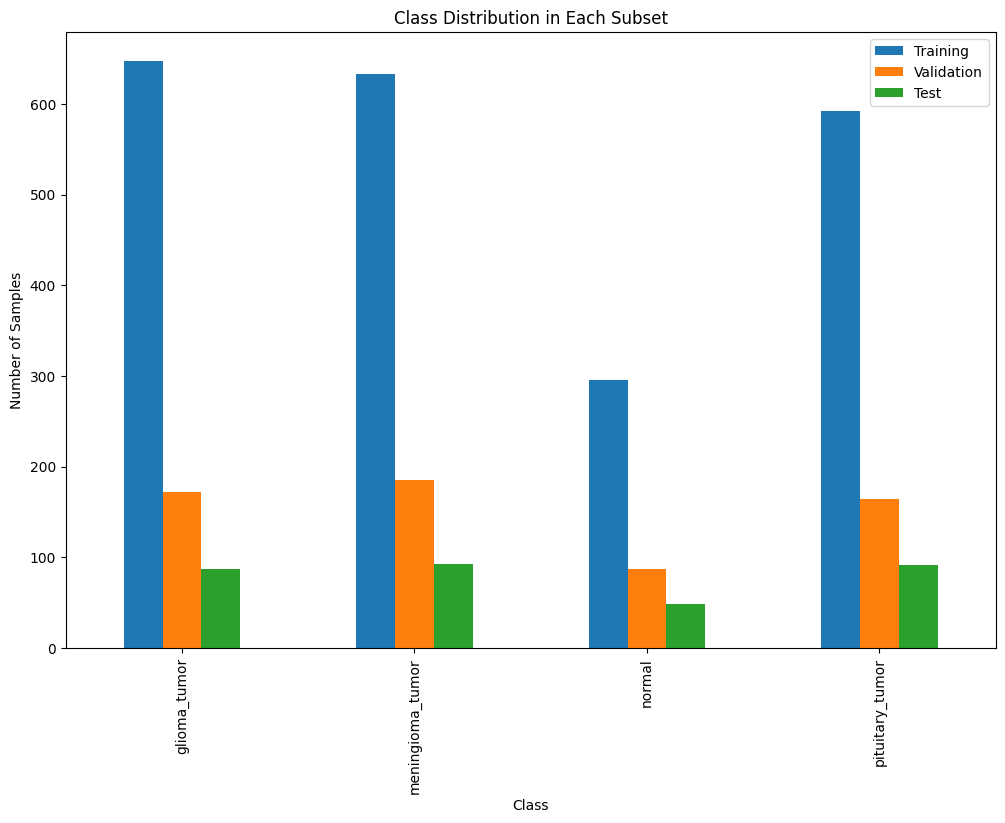

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to count labels in a dataset
def get_class_counts(dataset):
    labels = []
    for _, label_batch in dataset:
        labels.extend(label_batch.numpy())
    return np.bincount(labels)

# Get the class counts for each dataset
train_class_counts = get_class_counts(train_dataset)
val_class_counts = get_class_counts(final_val_dataset)
test_class_counts = get_class_counts(test_dataset)

# Create DataFrame to hold class distribution counts
class_counts_df = pd.DataFrame({
    'Class': class_names,
    'Training': train_class_counts,
    'Validation': val_class_counts,
    'Test': test_class_counts
})

# Plot the class distributions
class_counts_df.plot(x='Class', kind='bar', figsize=(12, 8))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Each Subset')
plt.show()


2024-11-09 16:36:18.154147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


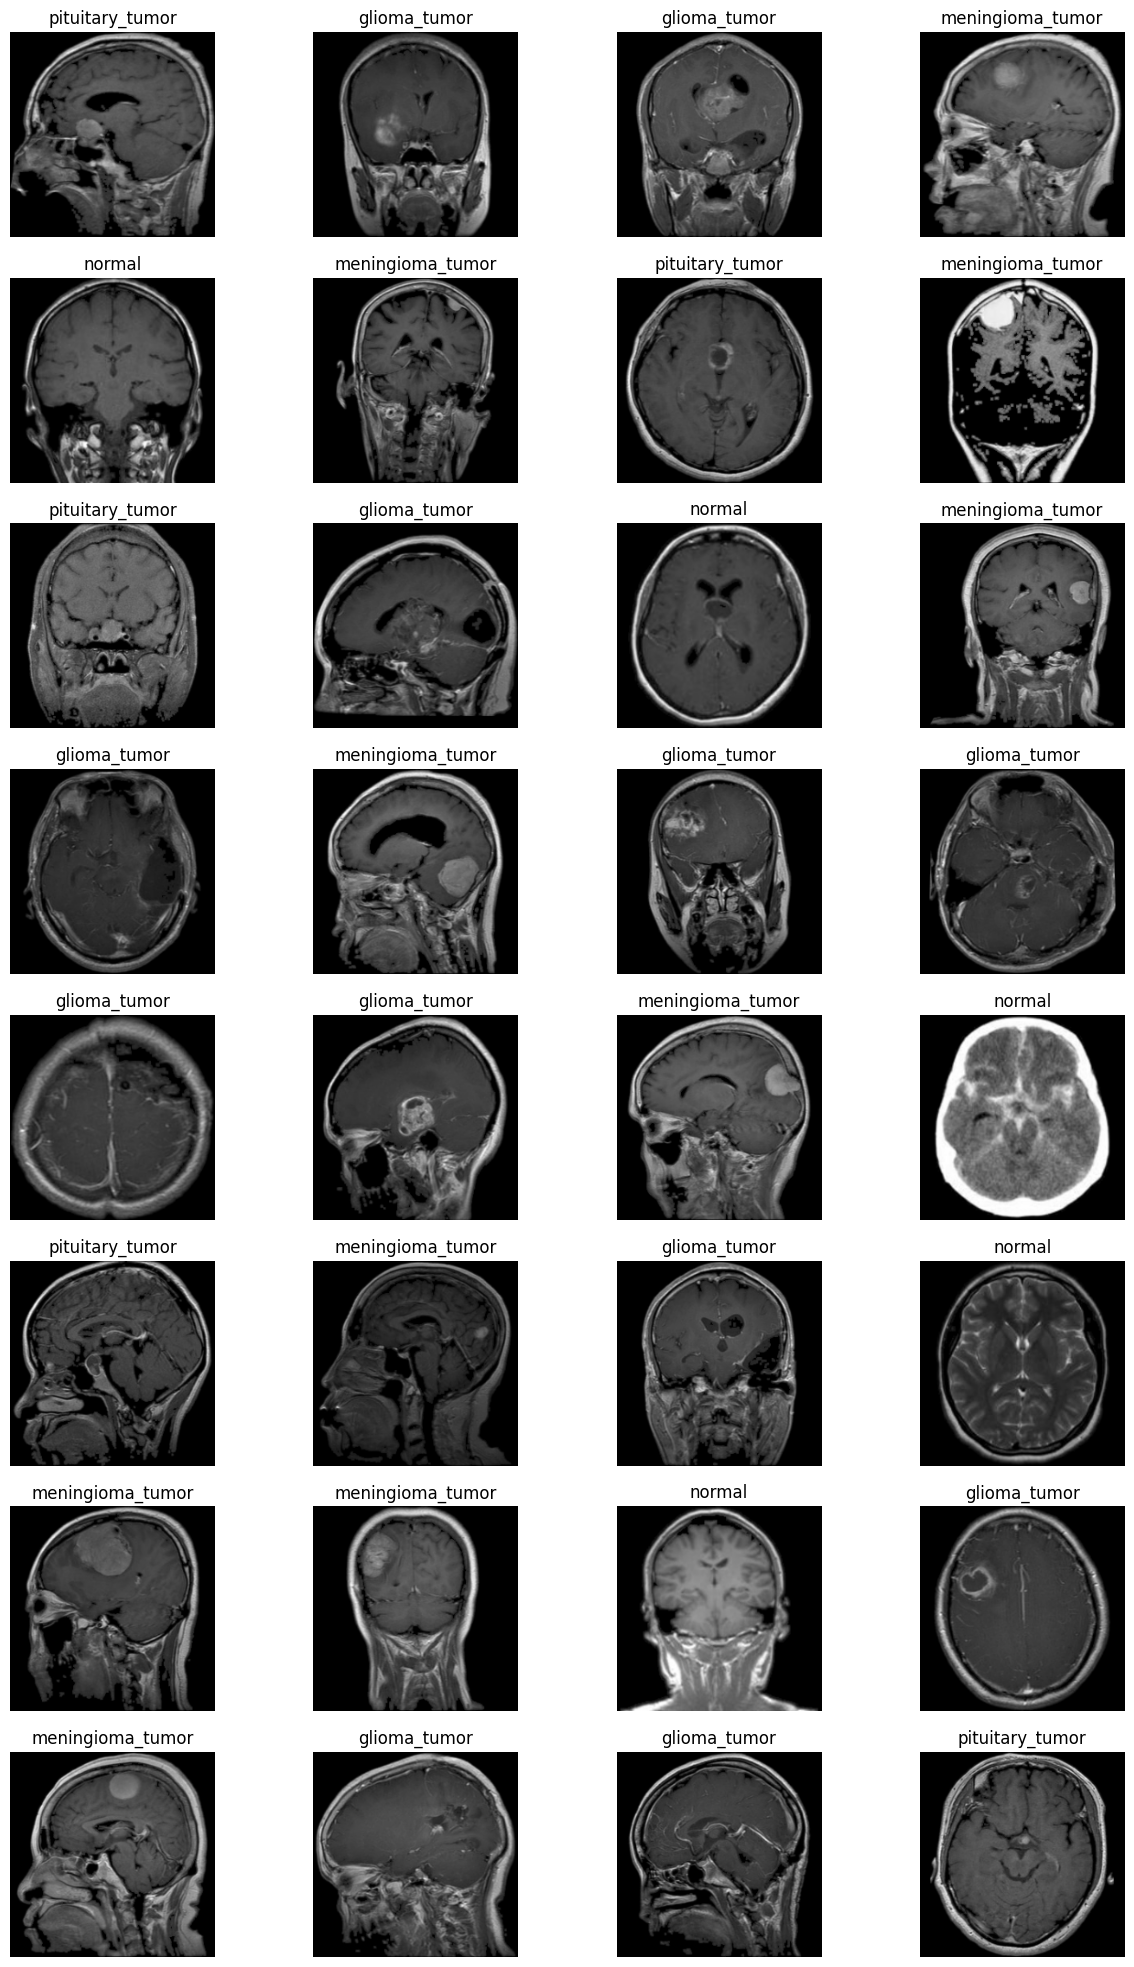

In [188]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [189]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [190]:
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='/Users/gamalielmarines/Desktop/reto benji/VGG16 Weights No Top.h5'
)

base_model.trainable = False

model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')  # Adjust to match the number of classes
])

# Build the model by calling it on a sample batch of data
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [191]:
checkpoint_cb = ModelCheckpoint("my_keras_model.keras", save_best_only=True)
# early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    train,
    epochs=15,
    validation_data=validation,
    callbacks=[checkpoint_cb]
)


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.5657 - loss: 11.3144 - val_accuracy: 0.8308 - val_loss: 2.3785
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.8523 - loss: 2.7326 - val_accuracy: 0.9256 - val_loss: 1.2363
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.9106 - loss: 1.4862 - val_accuracy: 0.9343 - val_loss: 1.0560
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.9165 - loss: 1.3351 - val_accuracy: 0.9526 - val_loss: 0.9481
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.9416 - loss: 0.9743 - val_accuracy: 0.9601 - val_loss: 1.1042
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.9460 - loss: 0.7633 - val_accuracy: 0.9537 - val_loss: 1.1900
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.9475 - loss: 0.9269 - val_accuracy: 0.9569 - val_loss: 1.2377
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.9573 - loss: 0.8263 - val_accuracy: 0.9709 - 

In [192]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9694 - loss: 1.2549
Test Loss = 1.8623379468917847
Test Accuracy = 0.9601293206214905


In [193]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.682657,7.847774,0.830819,2.378469
1,0.867159,2.372232,0.925647,1.236268
2,0.913745,1.515465,0.934267,1.055976
3,0.923432,1.186295,0.952586,0.948069
4,0.939576,1.086476,0.960129,1.104235
5,0.948801,0.879307,0.953664,1.190013
6,0.953413,0.927437,0.956897,1.237718
7,0.958948,0.799577,0.970905,0.920446
8,0.965867,0.714661,0.956897,1.157069
9,0.963100,0.877405,0.970905,1.181693


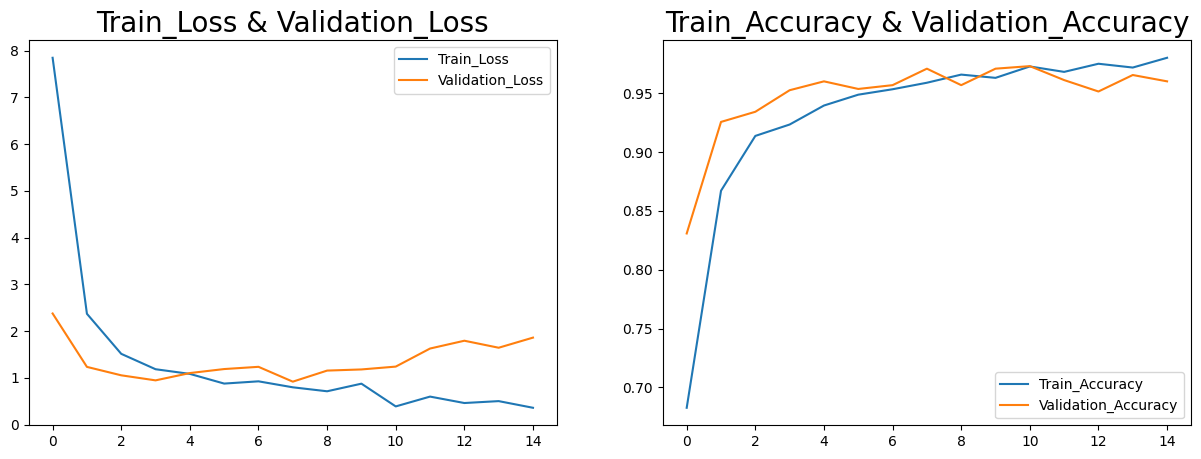

In [194]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [195]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

2024-11-09 18:03:06.195113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step


,Actual,Prediction
0,2,2
1,3,3
2,3,3
3,0,0
4,0,0
...,...,...
923,0,0
924,0,0
925,1,1
926,1,1


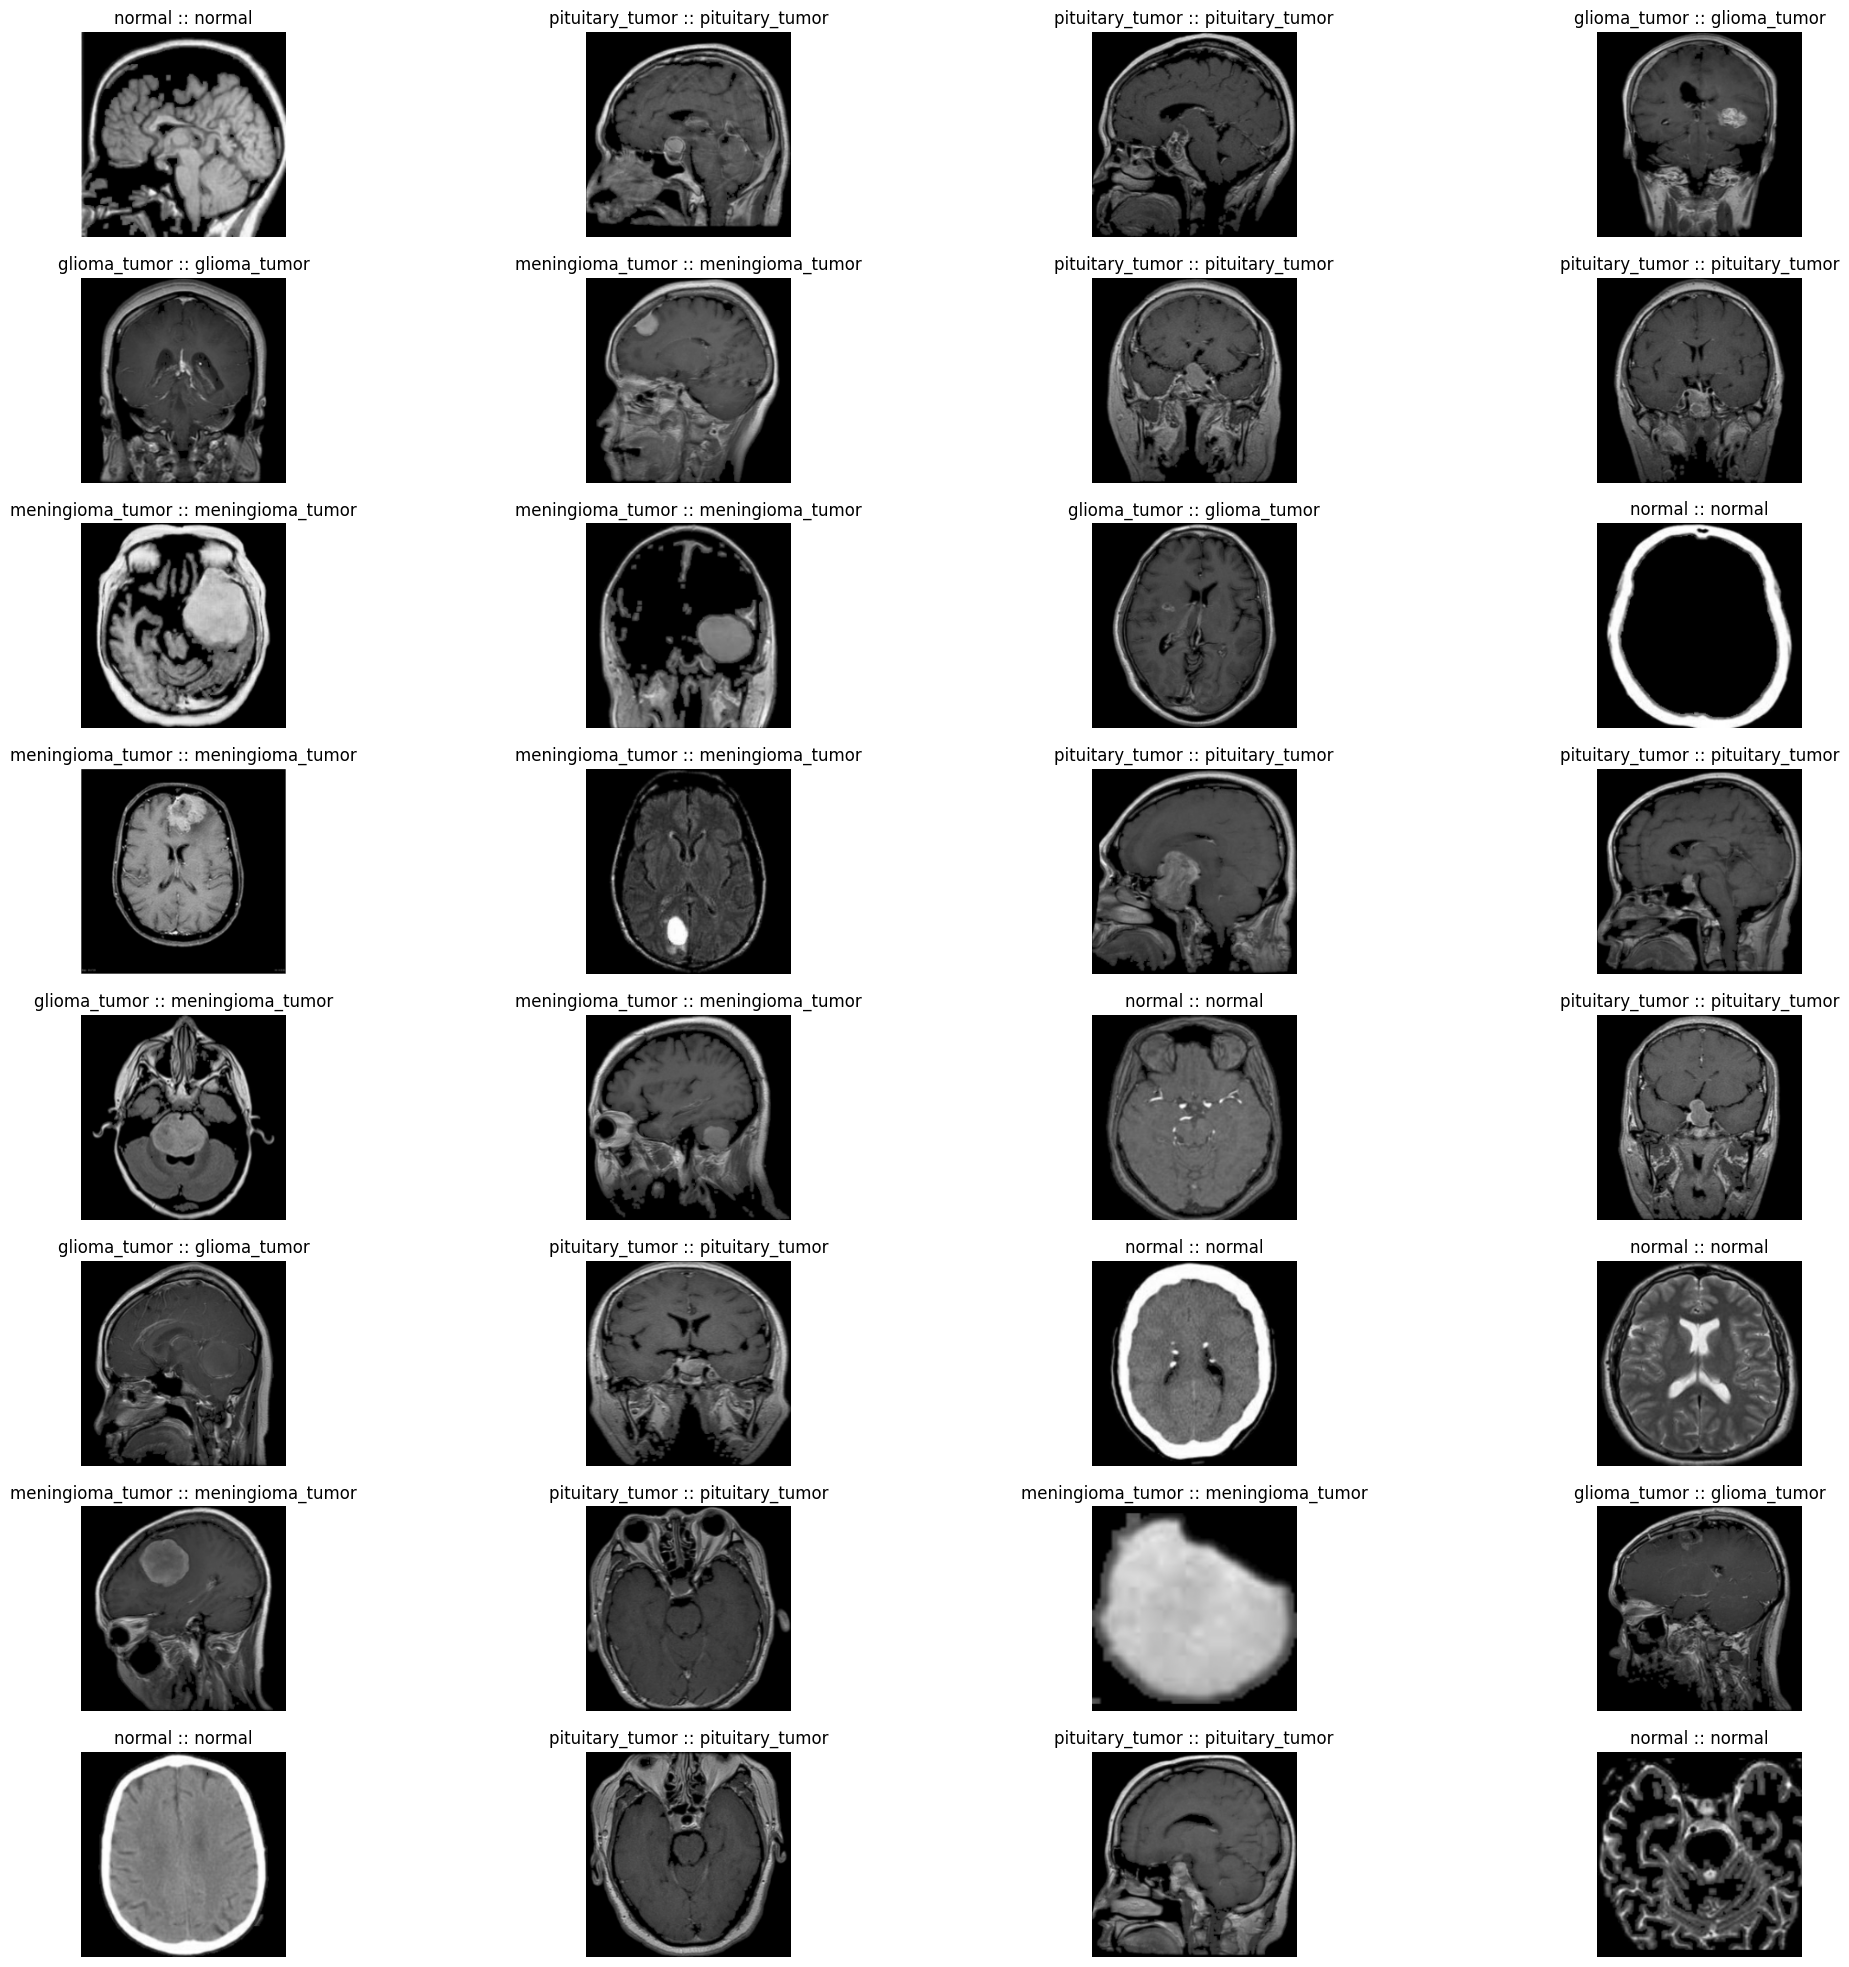

In [196]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

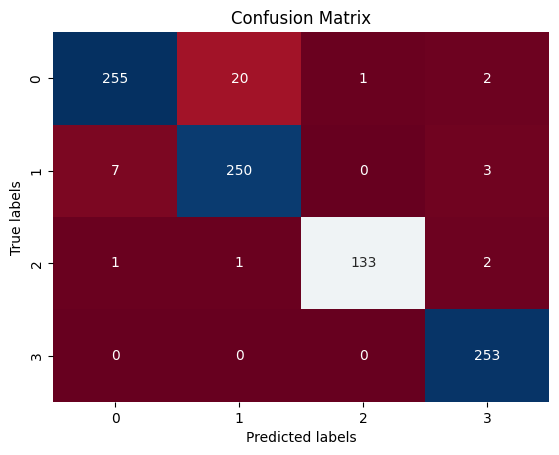

array([[255,  20,   1,   2],
       [  7, 250,   0,   3],
       [  1,   1, 133,   2],
       [  0,   0,   0, 253]])

In [197]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [198]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.97      0.92      0.94       278
           1       0.92      0.96      0.94       260
           2       0.99      0.97      0.98       137
           3       0.97      1.00      0.99       253

    accuracy                           0.96       928
   macro avg       0.96      0.96      0.96       928
weighted avg       0.96      0.96      0.96       928



In [199]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_images_from_folder(model, folder_path, target_size=(224, 224)):

    # List to store predictions
    predictions = []

    # Iterate over all files in the folder
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image

        # Make prediction
        pred = model.predict(img_array)
        pred_class = np.argmax(pred, axis=1)
        predictions.append((img_name, pred_class[0]))

    return predictions

# Example usage
folder_path = '/Users/gamalielmarines/Desktop/reto benji/img_predictions'
predictions = predict_images_from_folder(model, folder_path)
for img_name, pred_class in predictions:
    print(f"Image: {img_name}, Predicted Class: {class_names[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Image: nomral_brain2.jpeg, Predicted Class: normal
Image: normal_brain1.jpeg, Predicted Class: normal
Image: Normal Brain MRI.png, Predicted Class: normal
Image: Normal Brain MRI (1).png, Predicted Class: pituitary_tumor


In [1]:
import tkinter as tk
from tkinter import filedialog, Label
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict the selected image
def predict_single_image(model, img_path, target_size=(224, 224)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)
    return pred_class[0]

# Define class names for predictions
class_names = ['glimona tumor', 'meningioma tumor', 'normal', 'pituitary tumor']  # Replace with your actual class names

# Create tkinter window for selecting image and displaying prediction
def open_image():
    # Open file dialog to select image
    img_path = filedialog.askopenfilename()
    if img_path:
        # Display selected image in tkinter window
        img = Image.open(img_path)
        img = img.resize((224, 224))
        img_tk = ImageTk.PhotoImage(img)
        img_label.config(image=img_tk)
        img_label.image = img_tk

        # Predict the class using the model
        pred_class = predict_single_image(model, img_path)
        result_label.config(text=f"Predicted Class: {class_names[pred_class]}")

# Set up the tkinter GUI
root = tk.Tk()
root.title("Brain MRI Prediction")
root.geometry("300x400")

# Create and place labels for image and prediction result
img_label = Label(root)
img_label.pack(pady=20)

result_label = Label(root, text="Select an image to predict", font=("Arial", 14))
result_label.pack(pady=10)

# Button to select image
button = tk.Button(root, text="Select Image", command=open_image)
button.pack(pady=20)

root.mainloop()


2024-11-09 19:09:45.926496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 19:09:50.852 Python[63426:4446115] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/hx/jdv9z5kj44b5b90287xxdb1w0000gn/T/ipykernel_63426/5802260.py", line 36, in open_image
    pred_class = predict_single_image(model, img_path)
                                      ^^^^^
NameError: nam